# Programa Ingenias+ Data Science

## Objetivo del proyecto

Predecir si una persona tendrá hipertension alta o no, en base a sus hábitos y/o condiciones socioeconómicas

## Objetivo del notebook

El objetivo de este notebook es evaluar y comparar diversos algoritmos de clasificación para identificar cuál ofrece los mejores resultados en términos de precisión y otros parámetros de rendimiento. 

La variable objetivo en este análisis es **mantiene_ha_alta**, las columnas de características que se utilizarán en el notebook se detallan a continuación.


## Importación de archivos y librerías

In [17]:
# Imports de librerías y funciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import prince

from sklearn.preprocessing import LabelEncoder,  OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score


from utils.codificaciones import *
from utils.funcions import *
# pip install prince (por unica vez, si necesario)


In [40]:
# Importar el csv
friesgo = pd.read_csv('datasets/friesgo.csv')

## Preprocesado

### Identificación de variables

In [41]:
# Separar variables categóricas y numéricas
variables_categoricas = ['cod_provincia','tamanio_aglomerado','sexo','condicion_actividad','ansiedad_depresion'
                           ,'nivel_actividad_fisica','condicion_fumador','consumo_sal'
                           ,'colesterol_alto','freq_cons_alc','es_diabetico','mantiene_ha_alta']
variables_numericas = ['edad','media_fv_diaria','imc_numerico']

In [42]:
# Copiar el dataframe
friesgo_cod = friesgo.copy()

### Evaluación y procesamiento de nulos

In [43]:
calcular_nulos_y_porcentaje(friesgo_cod)

,Nulos,Porcentaje
id,0,0.0%
cod_provincia,0,0.0%
tamanio_aglomerado,0,0.0%
sexo,0,0.0%
edad,0,0.0%
condicion_actividad,0,0.0%
ansiedad_depresion,0,0.0%
nivel_actividad_fisica,226,0.84%
condicion_fumador,0,0.0%
mantiene_ha_alta,0,0.0%


In [44]:
# Eliminación de nulos
friesgo_cod = friesgo_cod.dropna()

In [45]:
calcular_nulos_y_porcentaje(friesgo_cod)

,Nulos,Porcentaje
id,0,0.0%
cod_provincia,0,0.0%
tamanio_aglomerado,0,0.0%
sexo,0,0.0%
edad,0,0.0%
condicion_actividad,0,0.0%
ansiedad_depresion,0,0.0%
nivel_actividad_fisica,0,0.0%
condicion_fumador,0,0.0%
mantiene_ha_alta,0,0.0%


### Codificación de columnas

In [46]:
# Visualización de filas y columnas
friesgo_cod.shape

(25539, 16)

In [47]:
# Codificación de columnas
le = LabelEncoder()
for columnas in variables_categoricas:
    friesgo_cod[columnas] = le.fit_transform(friesgo_cod[columnas])

In [48]:
# Evaluación de variable objetivo
friesgo_cod.mantiene_ha_alta.unique()

array([1, 0], dtype=int64)

In [49]:
# Evaluar que no haya pérdida de filas y/o columnas por la codificación
friesgo_cod.shape

(25539, 16)

### División del modelo en train-test

In [50]:
# Division del dataset en train-test en este caso el tamaño de la muestra sera del 30%
y = friesgo_cod['mantiene_ha_alta']
X = friesgo_cod.drop(columns=['mantiene_ha_alta','id'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Análisis de modelos

### Modelo 1: Regresión logística

#### Entrenamiento del modelo

In [57]:
# Crear el pipeline sólo con el clasificador
# max_iter se agrega como parámetro porque el número de iteraciones por defecto no son suficientes
modelo_rl = Pipeline(steps=[
    ('classifier', LogisticRegression(max_iter=500))
])

# Entrenar el modelo
modelo_rl.fit(X_train, y_train)

Pipeline(steps=[('classifier', LogisticRegression(max_iter=500))])

#### Evaluación del modelo

In [58]:
# Hacer predicciones
y_pred_rl = modelo_rl.predict(X_test)

# Evaluar el modelo
score = accuracy_score(y_test, y_pred_rl)

print(f'Exactitud del modelo: {score * 100:.2f}%')


Exactitud del modelo: 71.63%


#### Evaluación del rendimiento del modelo inicial

##### Matriz de confusión

In [59]:
# Matriz de confusion
matriz_confusion = confusion_matrix(y_test, y_pred_rl)
print('Matriz de Confusión:')
print(matriz_confusion)

Matriz de Confusión:
[[1494 1407]
 [ 767 3994]]


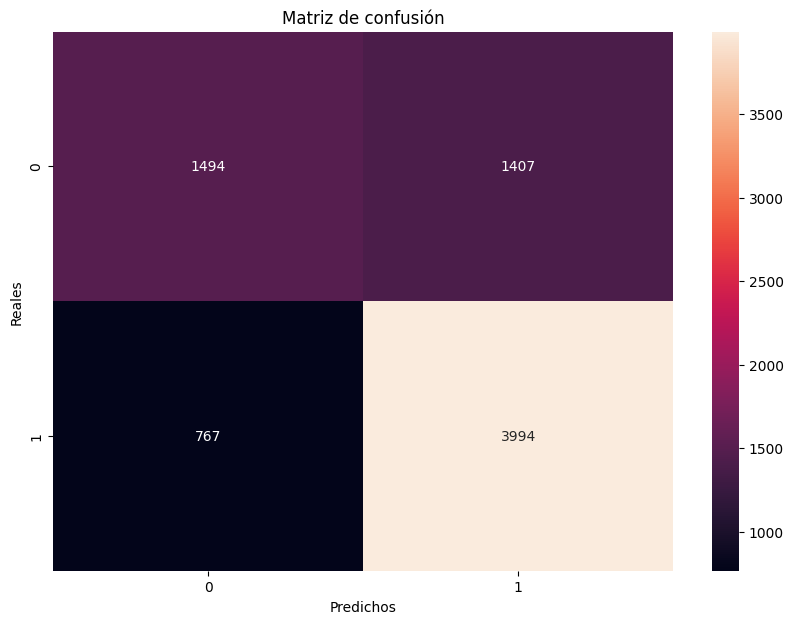

In [60]:
# Matriz de confusión - Gráfico
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusion, annot=True, cmap='rocket', fmt='d')
plt.xlabel('Predichos')
plt.ylabel('Reales')
plt.title('Matriz de confusión')
plt.show()

**Interpretación de la Matriz de Confusión**
* **1494: Verdaderos negativos (TN)** - Casos que fueron negativos y clasificados como negativos.
* **1407: Falsos positivos (FP)** - Casos que fueron negativos pero clasificados incorrectamente como positivos.
* **767: Falsos negativos (FN)** - Casos que fueron positivos pero clasificados incorrectamente como negativos.
* **3994: Verdaderos positivos (TP)** - Casos que fueron positivos y clasificados como positivos.


##### Reporte de clasificación

In [61]:
print(classification_report(y_test, y_pred_rl))

              precision    recall  f1-score   support

           0       0.66      0.51      0.58      2901
           1       0.74      0.84      0.79      4761

    accuracy                           0.72      7662
   macro avg       0.70      0.68      0.68      7662
weighted avg       0.71      0.72      0.71      7662



**Interpretación del Reporte de Clasificación**

**clase 0**: mantiene hipertension alta.

* **Precisión**: 66% de las predicciones fueron correctas.
* **Recall**: 51% de los casos reales fueron correctamente identificados.
* **F1-score**: 0.58, medida combinada de precisión y recall
* Existen 2901 casos reales en los datos de prueba

**clase 1**: no mantiene hipertension alta.

* **Precisión**: 74% de las predicciones fueron correctas.
* **Recall**: 84% de los casos reales fueron correctamente identificados.
* **F1-score**: 0.79, medida combinada de precisión y recall
* Existen 4761 casos reales en los datos de prueba

##### Ajuste de hiperparámetros

In [62]:
# Crear el GridSearchCV
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['newton-cg', 'lbfgs'],
    'classifier__penalty': ['l2', 'none']
}

grid_search_rl = GridSearchCV(modelo_rl, param_grid_lr, cv=5)

# Suprimir warnings durante la búsqueda de hiperparámetros
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_search_rl.fit(X_train, y_train)

# Mostrar el mejor estimador y el mejor puntaje
mejor_estimador_rl = grid_search_rl.best_estimator_

print("Mejor Estimador:\n", mejor_estimador_rl)

Mejor Estimador:
 Pipeline(steps=[('classifier',
                 LogisticRegression(C=0.1, max_iter=500, solver='newton-cg'))])


**Interpretación del Ajuste de hiperparámetros**

El resultado del ajuste es C = 0.1 y solver = 'newton-cg'. 

Esto significa que se debe seleccionar una regularización 'l2' relativamente fuerte con un C bajo y utilizar el solver de Newton-CG para la optimización.

#### Evaluación del modelo final

In [68]:
# Hacer predicciones
y_pred_mejor_rl = mejor_estimador_rl.predict(X_test)

# Evaluar el modelo
score_mejor_rl = accuracy_score(y_test, y_pred_mejor_rl)

print(f'Exactitud del nuevo modelo: {score_mejor_rl * 100:.2f}%')


Exactitud del nuevo modelo: 71.64%


#### Evaluación del rendimiento del modelo final

##### Matriz de confusión

In [64]:
# Matriz de confusion
matriz_confusion_mejor_rl = confusion_matrix(y_test, y_pred_mejor_rl)
print('Matriz de Confusión:')
print(matriz_confusion_mejor_rl)

Matriz de Confusión:
[[1495 1406]
 [ 767 3994]]


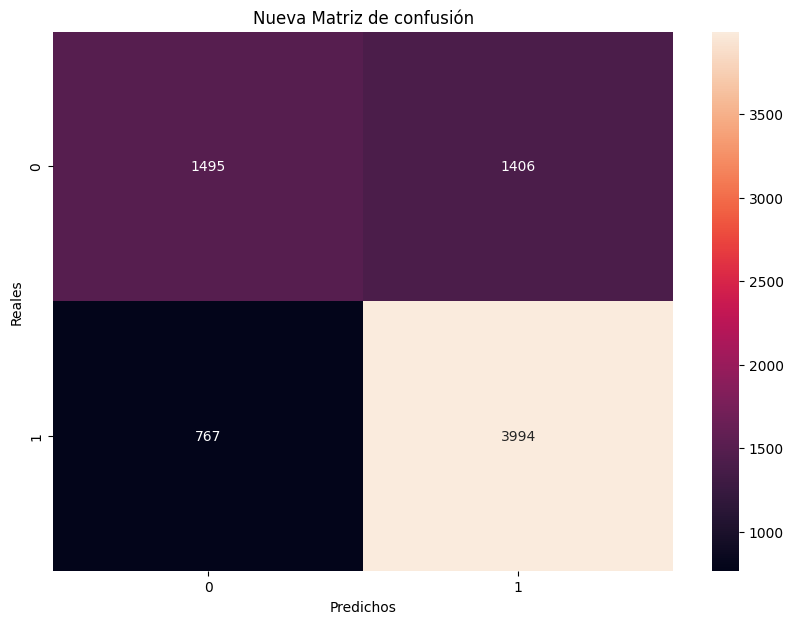

In [65]:
# Matriz de confusión - Gráfico
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusion_mejor_rl, annot=True, cmap='rocket', fmt='d')
plt.xlabel('Predichos')
plt.ylabel('Reales')
plt.title('Nueva Matriz de confusión')
plt.show()

**Interpretación de la Matriz de Confusión**
* **1495: Verdaderos negativos (TN)** - Casos que fueron negativos y clasificados como negativos.
* **1406: Falsos positivos (FP)** - Casos que fueron negativos pero clasificados incorrectamente como positivos.
* **767: Falsos negativos (FN)** - Casos que fueron positivos pero clasificados incorrectamente como negativos.
* **3994: Verdaderos positivos (TP)** - Casos que fueron positivos y clasificados como positivos.


##### Reporte de clasificación

In [66]:
print(classification_report(y_test, y_pred_mejor_rl))

              precision    recall  f1-score   support

           0       0.66      0.52      0.58      2901
           1       0.74      0.84      0.79      4761

    accuracy                           0.72      7662
   macro avg       0.70      0.68      0.68      7662
weighted avg       0.71      0.72      0.71      7662



**Interpretación del Reporte de Clasificación**

**clase 0**: mantiene hipertension alta.

* **Precisión**: 66% de las predicciones fueron correctas.
* **Recall**: 52% de los casos reales fueron correctamente identificados.
* **F1-score**: 0.58, medida combinada de precisión y recall
* Existen 2901 casos reales en los datos de prueba

**clase 1**: no mantiene hipertension alta.

* **Precisión**: 74% de las predicciones fueron correctas.
* **Recall**: 84% de los casos reales fueron correctamente identificados.
* **F1-score**: 0.79, medida combinada de precisión y recall
* Existen 4761 casos reales en los datos de prueba

##### Importancia de las columnas

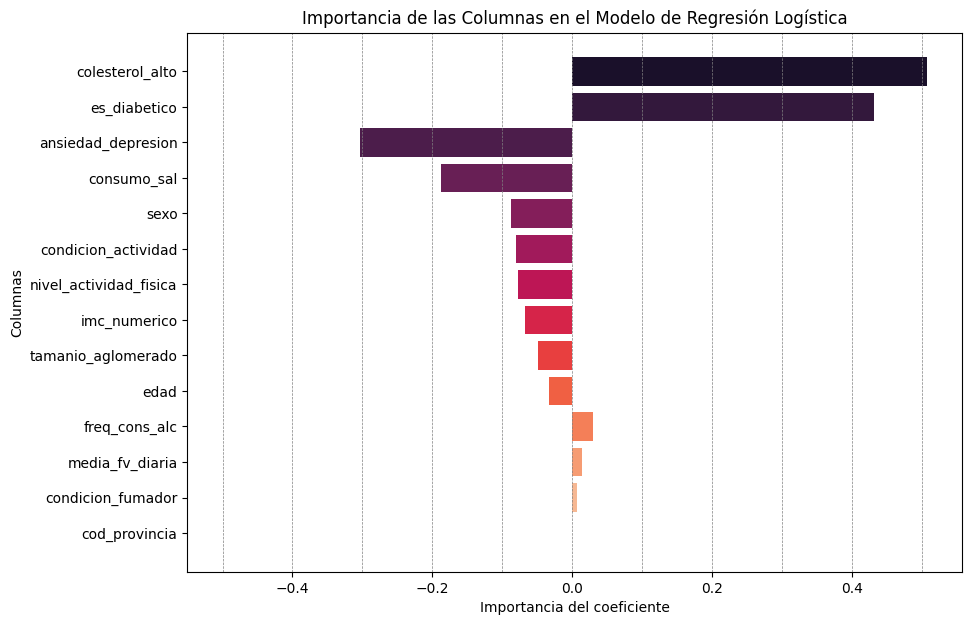

In [73]:
# Extraer el modelo de regresión logística del pipeline
modelo_columnas_rl = grid_search_rl.best_estimator_['classifier']

# Obtener los coeficientes y nombres de las columnas
coeficientes_rl = modelo_columnas_rl.coef_[0]
nombres_columnas_rl = X_train.columns

# Crear un DataFrame con los coeficientes y sus nombres
importancia_columnas = pd.DataFrame({
    'Columna': nombres_columnas_rl,
    'Importancia': coeficientes_rl
})

# Ordenar por la importancia absoluta de los coeficientes
importancia_columnas['Importancia_absoluta'] = np.abs(importancia_columnas['Importancia'])
importancia_columnas = importancia_columnas.sort_values('Importancia_absoluta', ascending=False)

# Paleta de colores
colors = sns.color_palette("rocket", n_colors=len(importancia_columnas))

# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 7))
plt.barh(
    importancia_columnas['Columna'], 
    importancia_columnas['Importancia'], 
    color=colors
)

# Añadir líneas verticales para los xlabels
for x in np.linspace(-0.5, 0.5, num=11):
    plt.axvline(x, color='gray', linestyle='--', linewidth=0.5)

# Añadir título y etiquetas
plt.title('Importancia de las Columnas en el Modelo de Regresión Logística')
plt.xlabel('Importancia del coeficiente')
plt.ylabel('Columnas')

 # Invertir el eje para que las columnas más importantes estén arriba
plt.gca().invert_yaxis() 

plt.show()

* Las columnas con coeficientes más altos (en valor absoluto) tienen un mayor impacto en la predicción. 

* Los coeficientes positivos y negativos indican si la columna incrementa o disminuye la probabilidad de **mantener hipertensión alta**, respectivamente.

* Para este modelo, identificamos 2 características con una gran incidencia **positiva**: colesterol_alto y es_diabetico. Esto indica que tener **colesterol alto** o **ser diabético** **AUMENTAN** las probabilidades de **ser hipertenso**.

* Por otro lado, identificamos 2 características con una gran incidencia **negativa**: ansiedad_depresion y consumo_sal. Esto indica que tener **ansiedad o depresión** o **consumir sal en exceso** **DISMINUYEN** las probabilidades de **ser hipertenso**.

#### Conclusiones
Los resultados del modelo de regresión logística, tanto antes como después del **Ajuste de Hiperparámetros**, muestran muy pocas diferencias en las métricas clave:

**Poco cambio en la exactitud**: aumentó de 71.63% a 71.64%.

**Estabilidad en la matriz de confusión**: ligera variación en el número de ejemplos correcta e incorrectamente clasificados.

**Métricas de clasificación similares**: las métricas de precisión, recall y f1-score para ambas clases (0 y 1) no han cambiado significativamente.

**CONCLUSIÓN GENERAL**: 

Dado que los resultados iniciales y finales son casi idénticos, es probable que el modelo esté limitado en su capacidad para mejorar con los datos y las características actuales. Eventualmente se podría incluir columnas adicionales que puedan mejorar las diferencias entre las clases.
Es posible que el modelo **Regresión Logística** no sea el más adecuado para los datos; se evaluarán otros modelos para comparar el desempeño de cada uno.

### Modelo 2: Random Forest

In [54]:
# Como realice el preprocesado en la primera seccion, voy a crear un pipeline solo con el clasificador
pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42,criterion= 'gini'))
])

In [55]:
# Creare tambien un diccionario con parametros para Gridsearch, que me ayudara a buscar los mejores parametros para mi modelo de modo mas rapido/automatizado
parametros = {
    'classifier__n_estimators': [150,200],
    'classifier__max_depth': [8,10],
    'classifier__min_samples_split': [2,4],
    'classifier__min_samples_leaf': [1] 
}

In [56]:
# Creo mi GridSearchCV
grid_search = GridSearchCV(pipeline, parametros, scoring='roc_auc',return_train_score = True,)

In [57]:
# Ajustar GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [8, 10],
                         'classifier__min_samples_leaf': [1],
                         'classifier__min_samples_split': [2, 4],
                         'classifier__n_estimators': [150, 200]},
             return_train_score=True, scoring='roc_auc')

In [71]:
#Guardo el modelo encontrado por gridsearch y que pude probar con mi notebook(sin que tarde 15min+)
mejor_modelo = grid_search.best_estimator_

In [72]:
matriz_conf

array([[1465, 1436],
       [ 705, 4056]], dtype=int64)

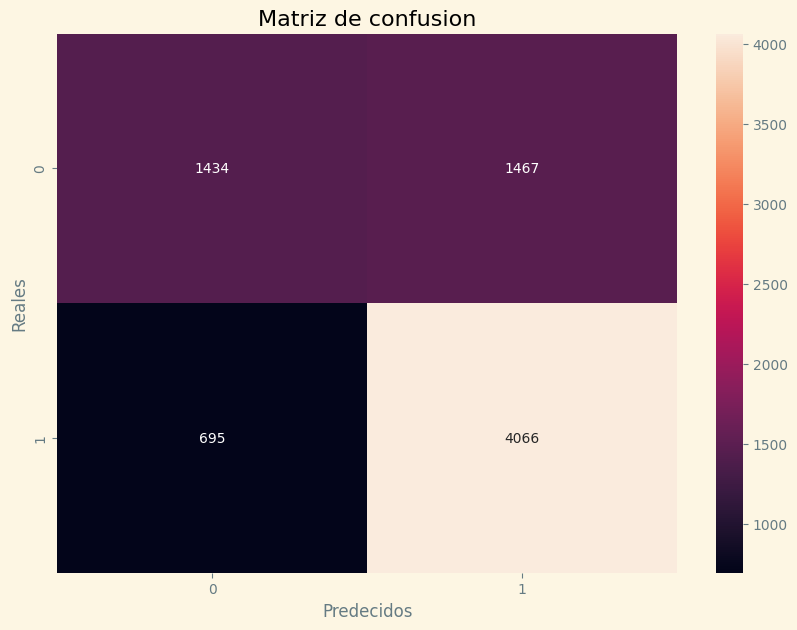

In [73]:
# Ahora de manera grafica 
matriz_conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_conf, annot=True, cmap='rocket', fmt='d')
plt.xlabel('Predecidos')
plt.ylabel('Reales')
plt.title('Matriz de confusion')
plt.show()

In [61]:
# Finalmente, evaluo el modelo viendo que tan bien predice mi variable objetivo, evaluandolo con el conjunto de datos de testeo
y_pred = mejor_modelo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.49      0.57      2901
           1       0.73      0.85      0.79      4761

    accuracy                           0.72      7662
   macro avg       0.70      0.67      0.68      7662
weighted avg       0.71      0.72      0.71      7662



In [62]:
# Creo una variable auxiliar para guardar las feature importances
feat = mejor_modelo.steps[0][1].feature_importances_

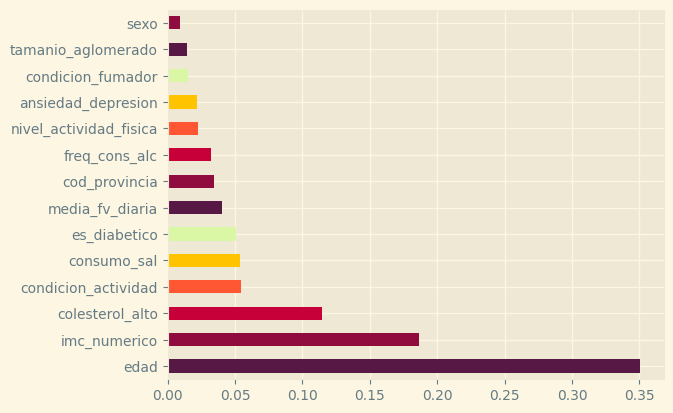

In [63]:
# Grafico las feature importances para saber cuales de mis caracteristicas seleccionadas tuvieron mas peso (a futuro podrian eliminarse aquellas que no para talvez optimizar los parametros)
feat_importances = pd.Series(feat , index=X.columns)
feat_importances.nlargest(20).plot(kind='barh',  color=['#581845','#900C3F','#C70039','#FF5733','#FFC300','#DAF7A6'])
plt.style.use('Solarize_Light2')
plt.show()

Las etiquetas son para 'mantiene_ha_alta'
0:SI
1:NO

__En conclusion__ 

Tras evaluar una serie de parametros para este modelo y elegir el mejor obseramos:
+ El reporte de clasificacion (classification_report(y_test, y_pred)) nos indica que el modelo tiene una exactitud del 72% en la prediccion de nuevas etiquetas. Particularmente predice con una presicion del 67% las etiquetas correspondientes a la clase 0 (mantiene hipertension alta) y con una presicion del 73% para las correspondientes a clase 1 (no mantiene hipertension alta), entonces podria decirse que este modelo funciona mejor para predecir a aquellos individuos que efectivamente no tienen hipertencion arterial alta.
+ El grafico de la matriz de confusion nos indica que: 

    + 705 casos fueron predichos como 0(hipertensos) cuando eran 1(no hipertensos) 
    + 1434 casos fueron predecidos como 1(no hipertensos) cuando eran 0(hipertensos)
    + 1467 casos fueron predecidos como 0(hipertensos) cuando eran 0(hipertensos)
    + 4056 casos fueron predecidos como 1(no hipertensos) cuando eran 1(no hipertensos)

Entonces, solo el 49% de aquellos etiquetados como hipertensos fueron etiquetados correctamente, mientras que el 85% de los etiquetados como no hipertensos fue etiquetado correctamente.

+ Feature importance, las caracteristicas que mas parecen importar para el modelo durante la clasificacion son: la edad, el imc y si tiene colesterol alto.

In [51]:
friesgo_cod.shape

(25539, 16)

In [69]:
pd.Series(y_pred).value_counts()

1    5533
0    2129
Name: count, dtype: int64

In [70]:
y_test.value_counts()

mantiene_ha_alta
1    4761
0    2901
Name: count, dtype: int64

### Modelo 3

Clasficiación con Support Vector Machine

Lo que hace SVM es encontrar un hiperplano (clasificador), que separe las clases.
Las SVM permiten elegir la mejor entre muchas fronteras, de modo que garantiza una mayor probabilidad de etiquetar correctamente a los datos a clasificar.

In [85]:
#Visualización del dataset al que queremos aplicar el modelo, contiene los factores y la variable con que deseamos clasificar
friesgo_cod

,id,cod_provincia,tamanio_aglomerado,sexo,edad,condicion_actividad,ansiedad_depresion,nivel_actividad_fisica,condicion_fumador,mantiene_ha_alta,consumo_sal,media_fv_diaria,colesterol_alto,freq_cons_alc,es_diabetico,imc_numerico
0,1128639,0,0,0,32,0,1,0,2,1,3,4.00,1,5,1,32.36
1,1709939,0,0,1,65,0,1,0,2,1,2,6.43,0,5,1,25.39
2,6874130,0,0,1,33,0,0,1,1,1,0,2.86,1,2,1,17.97
3,10319375,0,0,1,64,0,1,2,0,1,1,1.43,0,1,1,22.89
4,11140857,0,0,0,24,0,1,1,2,1,2,1.43,1,5,1,21.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26984,2092256226,23,3,1,26,0,1,1,0,1,2,3.43,1,5,1,23.63
26985,2097771079,23,3,0,62,1,1,2,0,0,2,2.86,0,5,1,30.16
26986,2101464264,23,3,1,74,0,0,0,2,0,2,3.14,0,0,1,26.99
26987,2116612011,23,3,1,44,0,0,1,0,1,1,1.00,1,0,0,23.61


Las SVM que trabajan bien en espacios dimensionales elevados y son pesadas de correr con datasets grandes.

Los datos no linealmente separables requieren la utilización de Kernels, que proyectan los datos en un espacio donde sea fácil encontrar el hiperplano que los separe correctamente (el modelo hace este proceso implícitamente). 
No es sencillo selección el Kernel (núcleo) que nos de el mejor espacio de proyección para los datos.

El caso mas sencillo serían linealmente separales, de caso contrario, deberá incluirse un Kernel en el modelado.

Visualizacion de la DISTRIBUCION de los datos

Para entender la distribución de nuestros datos se decide hacer una reudcción de dimensionalidad utilizando el método FAMD de la librería Prince.
Es un análisis factorial para datos mixtos, ya que coexisten variables categóricas(requiere sean tipo int) y numéricas(float) sin nulos.

Un análisis de componentes principales crea nuevos componentes (ejes) que son combinaciones lineales de las variables originales, que mantienen la mayor cantidad posible de información (varianza).
La reducción de de dimensiones implica una pérdida de información, el análisis de estos resultados será cualitativo y con intención de visualizar algunos patrones generales.

In [56]:
#Visualizaremos nuestro dataset, eliminando primero la columna id, que no es una variable a analizar
subset_FAMD = friesgo_cod.drop('id', axis=1)

In [57]:
subset_FAMD.head()

,cod_provincia,tamanio_aglomerado,sexo,edad,condicion_actividad,ansiedad_depresion,nivel_actividad_fisica,condicion_fumador,mantiene_ha_alta,consumo_sal,media_fv_diaria,colesterol_alto,freq_cons_alc,es_diabetico,imc_numerico
0,0,0,0,32,0,1,0,2,1,3,4.00,1,5,1,32.36
1,0,0,1,65,0,1,0,2,1,2,6.43,0,5,1,25.39
2,0,0,1,33,0,0,1,1,1,0,2.86,1,2,1,17.97
3,0,0,1,64,0,1,2,0,1,1,1.43,0,1,1,22.89
4,0,0,0,24,0,1,1,2,1,2,1.43,1,5,1,21.46


In [70]:
subset_FAMD.shape

(25539, 15)

In [86]:
subset_FAMD.dtypes

cod_provincia               int64
tamanio_aglomerado          int64
sexo                        int64
edad                        int64
condicion_actividad         int64
ansiedad_depresion          int64
nivel_actividad_fisica      int64
condicion_fumador           int64
mantiene_ha_alta            int64
consumo_sal                 int64
media_fv_diaria           float64
colesterol_alto             int64
freq_cons_alc               int64
es_diabetico                int64
imc_numerico              float64
dtype: object

El subset a analizar no requiere más transformaciones.

In [58]:
#Análisis de factores de datos mixtos
famd = prince.FAMD(n_components=3)
famd.fit(subset_FAMD)

c:\Users\Lenovo\anaconda3\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-2.3054811544020026, -1.0040541960937024, -0.42027588320511244, -0.5741027384922807, -1.1195870119524907, -0.4259900930995084, -0.6637480652968891, -0.48019632619170105, -0.4571158842931706, -0.4626501764770823, -0.6015954354993281, -0.44726612543442, -0.47379342201283137, -0.34879374061963664, -0.3981977095285227, -0.48389222929574954, -0.49967686022299634, -0.41632097331877366, -0.5782989674549202, -0.5305573040676068, -0.38783631763918763, -0.45376291078099207, -0.3498865696388053, -0.6434999399808781, -0.35708663617497444, -0.45961456246255294, -0.26455811113210204, -1.2320364357137932, -2.2140268107377494, -0.28314572645208996, -1.9780353460493185, -0.5343811899724816, -1.5171726709847986, -1.1511940151168674, -1.1644928930113054, -1.9541516424487804, -0.7882039808870032, -1.120268786304899, -1.8217000780266956, -1.1424277468016784, -0.2817941

FAMD(n_components=3)

In [59]:
#Coordenadas de los datos en los 3 ejes recién calculados
row_coord_FAMD = famd.row_coordinates(subset_FAMD)

c:\Users\Lenovo\anaconda3\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-2.3054811544020026, -1.0040541960937024, -0.42027588320511244, -0.5741027384922807, -1.1195870119524907, -0.4259900930995084, -0.6637480652968891, -0.48019632619170105, -0.4571158842931706, -0.4626501764770823, -0.6015954354993281, -0.44726612543442, -0.47379342201283137, -0.34879374061963664, -0.3981977095285227, -0.48389222929574954, -0.49967686022299634, -0.41632097331877366, -0.5782989674549202, -0.5305573040676068, -0.38783631763918763, -0.45376291078099207, -0.3498865696388053, -0.6434999399808781, -0.35708663617497444, -0.45961456246255294, -0.26455811113210204, -1.2320364357137932, -2.2140268107377494, -0.28314572645208996, -1.9780353460493185, -0.5343811899724816, -1.5171726709847986, -1.1511940151168674, -1.1644928930113054, -1.9541516424487804, -0.7882039808870032, -1.120268786304899, -1.8217000780266956, -1.1424277468016784, -0.2817941

Visualización gráfica de los datos, su posición está definida por su valor en las variables analizadas, y su color indica su valor en nuestra a clasificar: mantiene_ha_alta.
Se ve un patrón general que diferencia dos grupos, pero también un importante solapamiento de ambos.
Se concluye que será necesaria la utilización de un Kernel en el modelo de SVC, para encontrar una división entre clases más clara. 

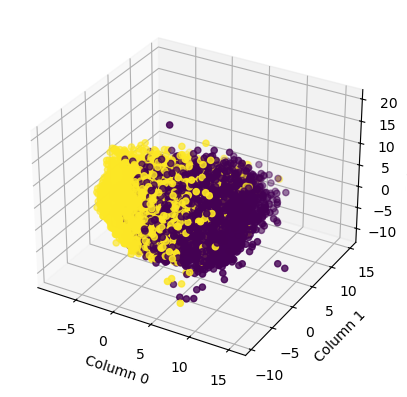

In [83]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(row_coord_FAMD.iloc[:, 0], row_coord_FAMD.iloc[:, 1], row_coord_FAMD.iloc[:, 2], c=subset_FAMD.mantiene_ha_alta)

ax.set_xlabel('Column 0')
ax.set_ylabel('Column 1')
ax.set_zlabel('Column 2')

plt.show()

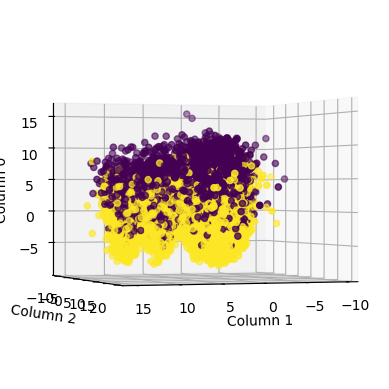

In [64]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(row_coord_FAMD.iloc[:, 1], row_coord_FAMD.iloc[:, 2], row_coord_FAMD.iloc[:, 0], c=subset_FAMD.mantiene_ha_alta)

ax.set_xlabel('Column 1')
ax.set_ylabel('Column 2')
ax.set_zlabel('Column 0')
ax.view_init(elev=0, azim=70)
plt.show()

Modelado

Para seleccionar los hiperparámetros del modelo se utiliza la función RandomizedSearchCV, que modela utilizando cierta cantidad de combinaciones de los parámetros que se desea probar, y evalúa la calidad de cada modelo para determinar la mejor combinación de parámetros que obtuvo.

Debido al elevado tiempo de procesamiento de dicha función se utilizará un subset de los datos de entrenamiento(50%, adecuado puesto que la variable a categorizar no está desbalanceada, y gráficamente no se ve una gran dispersión de los datos de ninguna clase) y un solo parámetro de Kernel ( Radial Basis Function ), el más flexible y que según la teoría se adapta bien a la superposición de clases detectada.

In [89]:
#Subsets más pequeños para la función RandomizedSearchCV
X_subset_SVC = X_train.sample(frac=0.5, random_state=42)
y_subset_SVC = y_train.sample(frac=0.5, random_state=42)

In [90]:
X_subset_SVC

,cod_provincia,tamanio_aglomerado,sexo,edad,condicion_actividad,ansiedad_depresion,nivel_actividad_fisica,condicion_fumador,consumo_sal,media_fv_diaria,colesterol_alto,freq_cons_alc,es_diabetico,imc_numerico
8385,3,3,1,26,2,0,2,2,2,0.71,1,2,1,41.12
16470,22,1,1,67,2,0,2,2,2,2.00,1,0,1,50.64
23325,6,2,1,29,0,0,1,0,1,1.14,1,0,1,21.76
17284,4,3,1,59,2,0,2,2,2,3.71,1,5,1,43.28
20687,13,3,1,79,2,0,1,2,2,0.71,0,0,1,23.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11831,20,3,0,70,2,0,1,1,3,4.00,0,5,0,29.43
17689,4,3,1,53,0,0,1,2,2,4.00,1,0,1,46.87
4787,1,3,0,31,0,0,0,1,1,1.14,1,5,1,32.51
20132,13,3,1,73,2,1,1,1,2,3.00,1,5,1,28.34


In [71]:
#Hiperparámetros a probar con RandomizedSearchCV
param_grid_SVC = {
       'C': [0.1, 1, 10],
       'gamma': [1, 0.1, 0.01],
       'kernel': ['rbf'],

   }

In [72]:
svc = SVC()

In [91]:
grid_SVC = RandomizedSearchCV(svc, param_grid_SVC, n_iter=10, cv=3, verbose=3, n_jobs=-1)
grid_SVC.fit(X_subset_SVC, y_subset_SVC)  # Use a subset of your data

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits


RandomizedSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': [1, 0.1, 0.01],
                                        'kernel': ['rbf']},
                   verbose=3)

In [93]:
#Para los modelos SVC, evalúa la calidad del modelo resultante de cada combinación de parámetros utilizando su Accuracy.
#El mejor resultado fue
grid_SVC.best_score_

0.7095541647610831

In [92]:
#El mejor modelo surgió de los hiperparámetros
best_SVC=grid_SVC.best_estimator_
best_SVC

SVC(C=1, gamma=0.01)

Aplicación y evaluación del modelo

In [76]:
#se utiliza el dataset con todos los registros
y_pred_SVC = best_SVC.predict(X_test)


In [77]:
from sklearn.metrics import accuracy_score

In [79]:
accuracy = accuracy_score(y_test, y_pred_SVC)
print("Accuracy:", accuracy)

Accuracy: 0.7039937353171496


In [80]:
print(classification_report(y_test, y_pred_SVC))

              precision    recall  f1-score   support

           0       0.63      0.52      0.57      2901
           1       0.74      0.82      0.77      4761

    accuracy                           0.70      7662
   macro avg       0.68      0.67      0.67      7662
weighted avg       0.70      0.70      0.70      7662



In [102]:
y_test.count()

7662

In [107]:
#Matriz de confusión, en porcentaje 
cm_SVC=confusion_matrix(y_test, y_pred_SVC)
cm_percent_SVC=cm_SVC/y_test.count()*100
print(cm_SVC)
print(cm_percent_SVC)


[[1511 1390]
 [ 878 3883]]
[[19.72069956 18.14147742]
 [11.45914905 50.67867398]]


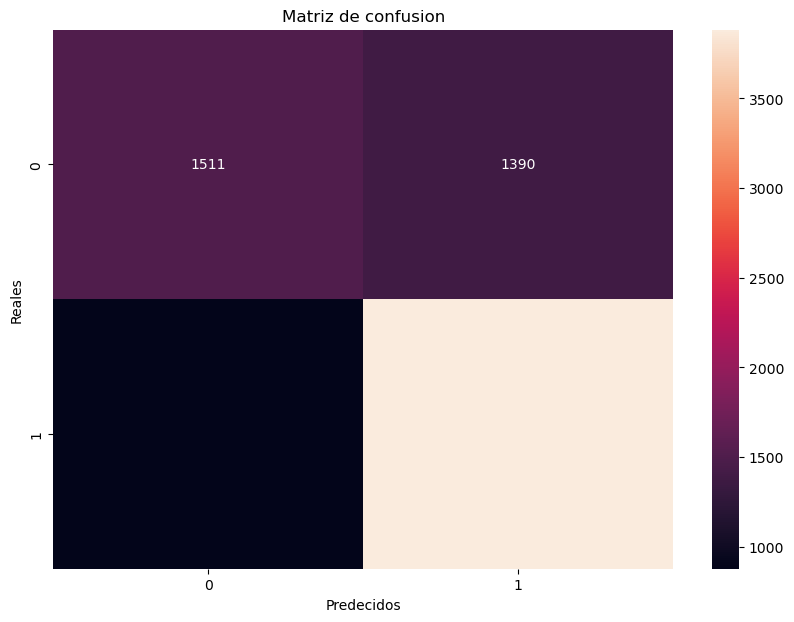

In [98]:
# Matríz de confusión
matriz_conf = confusion_matrix(y_test, y_pred_SVC)

plt.figure(figsize=(10, 7))
sns.heatmap(matriz_conf, annot=True, cmap='rocket', fmt='d')
plt.xlabel('Predecidos')
plt.ylabel('Reales')
plt.title('Matriz de confusion')
plt.show()


Análisis final del modelo
Los resultados no son satisfactorios
Es particularmente notorio con la clase mantiene_ha_alta=0
Y es mucho más preciso al identificar cuando mantiene_ha_alta=1

de 7662 clasificados
1511 fueron clasificados 0 y era correcto (19.72%)
3883 fueron clasificados 1 y era correcto (50.68%)
1390 fueron clasificados 1 era incorrecto (18.14%)
878 fueron clasificados 0 y era incorrecto (11.46%)

El modelo acertó un 70% de los casos

Con mayores recursos, debería entrensarse el modelo con el dataset de entrenamiento completo, y también probar más hiperparámetros.

Finalmente, viendo los resultados de los modelos anteriores, puede deberse a una gran variabilidad en los parámetros de individuos que no tienen hipertención (mantienen_ha_alta=0).
Podrían reconsiderarse los factores que componen a la matriz X, y dejar solo los más influyentes.  